<a href="https://colab.research.google.com/github/crisjosil/MT-PolSAR-Change-Detection-For-Crop-Monitoring-And-Classification/blob/master/AgriSAR_test_NNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminars: Imports, load datasets

In [ ]:
!pip install fiona
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# python
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt 
from collections import Counter
import fiona
import os
from itertools import product
from __future__ import print_function
from functools import partial
import pandas as pd
import itertools
from google.colab import files
#sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler    
from sklearn.preprocessing import Normalizer 
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.utils import class_weight
# imblearn
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.metrics import classification_report_imbalanced

# Keras
import keras
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
import keras.backend as K
# Tensor flow
import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)
tf.test.gpu_device_name()

2.4.0


'/device:GPU:0'

In [ ]:
version = 'V10/'

### Read change matrices

In [ ]:
# # Change matrices
root="/content/drive/My Drive/Datasets/AgriSAR_Paper2/Final_datasets/CM/"+version
#var='_.npy'
var='_with_diag.npy'#
layer_name = "y_train"+var
y_train_CM0=np.load(root + layer_name,  allow_pickle=True)
layer_name = "y_test"+var
y_test_CM0=np.load(root + layer_name,  allow_pickle=True)

print("Reading CM datasets ...")
layer_name = "X_train"+var
X_train_CM0=np.load(root + layer_name,  allow_pickle=True)
X_train_CM0 = np.nan_to_num(X_train_CM0)
print("Reading testing data ...")
layer_name = "X_test"+var
X_test_CM0=np.load(root + layer_name,  allow_pickle=True)
X_test_CM0 = np.nan_to_num(X_test_CM0)
print("Reading validation data ...")
layer_name = "X_val"+var
X_train_CM0_lev2=np.load(root + layer_name,  allow_pickle=True)
X_train_CM0_lev2 = np.nan_to_num(X_train_CM0_lev2)
print("Done")

Reading CM datasets ...
Reading testing data ...
Reading validation data ...
Done


In [ ]:
N_images=7
N_features=16
X_train_CM0_2d=X_train_CM0.reshape(X_train_CM0.shape[0],N_images,N_images,3)
X_test_CM0_2d=X_test_CM0.reshape(X_test_CM0.shape[0],N_images,N_images,3)
sc = MinMaxScaler()
X_train_CM = sc.fit_transform(X_train_CM0)
X_test_CM = sc.transform(X_test_CM0)

print("Reshaping as 2d images ...")
X_train_CM_2d=X_train_CM.reshape(X_train_CM.shape[0],N_images,N_images,3)
X_test_CM_2d=X_test_CM.reshape(X_test_CM.shape[0],N_images,N_images,3)

X_for_training=X_train_CM_2d
X_for_testing= X_test_CM_2d

Reshaping as 2d images ...


# Custom Loss function for imbalanced classification


*   Uses weighted categorical cross entropy




### Class and sample_weights

Note that here we give more weights to the classes and samples with lower number of samples represented in the training data

In [ ]:
y_tr = y_train_CM0 # Enable for CM
#y_tr = y_train0 # enable for PolSAR

In [ ]:
# Determine weight of each class according to number of samples
# For train
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_tr),
                                                 y_tr)
class_weight_dict = dict(enumerate(class_weights/class_weights.max())) # normalize the weights to one

sample_weight=np.zeros(y_tr.shape)
for r in np.unique(y_tr):
  sample_weight=np.where(y_tr==r,class_weight_dict[r],sample_weight)

print(np.unique(sample_weight))
print(class_weight_dict)

[0.08512003 0.10249292 0.1854931  0.24772562 0.40229221 0.49246725
 0.50581375 0.55434255 0.99131552 1.        ]
{0: 0.5058137473855862, 1: 0.9913155243686387, 2: 0.1024929156086471, 3: 0.4924672545602016, 4: 0.18549309690335666, 5: 0.402292207059885, 6: 0.5543425474465317, 7: 0.24772561547275948, 8: 1.0, 9: 0.0851200276803398}


In [ ]:
# Custom loss function with costs
def w_categorical_crossentropy(y_true, y_pred, weights):
    nb_cl = len(weights)
    final_mask = K.zeros_like(y_pred[:, 0])
    y_pred_max = K.max(y_pred, axis=1)
    y_pred_max = K.expand_dims(y_pred_max, 1)
    y_pred_max_mat = K.equal(y_pred, y_pred_max)
    for c_p, c_t in product(range(nb_cl), range(nb_cl)):

        final_mask += (K.cast(weights[c_t, c_p],K.floatx()) * K.cast(y_pred_max_mat[:, c_p] ,K.floatx())* K.cast(y_true[:, c_t],K.floatx()))
    return K.categorical_crossentropy(y_pred, y_true) * final_mask

In [ ]:
# Array with weights
w_array = np.ones((10,10))
for i in range(10):
  w_array[:,i]=class_weight_dict[i]
for i in range(10):
  w_array[i,i]=1
#w_array

In [ ]:
ncce = partial(w_categorical_crossentropy, weights=w_array)
ncce.__name__ ='w_categorical_crossentropy'

# Performance with 10 classes

In [ ]:
def eval_model(y_test0,y_pred,classes,model_name):
  df_metrics_w=pd.DataFrame(index=['f1_macro','G_mean_macro','Balanced accuracy','Imbalanced accuracy'])
  f1_macro = f1_score(y_test0, y_pred, average='macro')
  G_mean_macro = geometric_mean_score(y_test0, y_pred, average='macro', sample_weight=None)
  Bal_acc = balanced_accuracy_score(y_test0, y_pred, sample_weight=None, adjusted=False)
  Imbal_acc = accuracy_score(y_test0, y_pred)

  list_of_metrics=[f1_macro,G_mean_macro,Bal_acc,Imbal_acc]
  df_metrics_w["NN_All_small"] = list_of_metrics   
  print(df_metrics_w)
  print(" ")
  report = classification_report(y_test0,y_pred,target_names=classes,output_dict=True)
  df_report = pd.DataFrame(report).transpose()
  print(df_report)
  print(" ")
  df_metrics_w.to_csv(model_name+'_metrics.csv')
  files.download(model_name+'_metrics.csv')
  df_report.to_csv(model_name+'_report.csv')
  files.download(model_name+'_report.csv')
  #files.download(model_name+'.h5') #"birds.h5"

def plot_my_confusion_matrix(cm, classes,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues,
                        save=0,model_name=""):
    """
    This function prints and plots the confusion matrix.
    """
    fig,ax=plt.subplots(1,figsize=(12,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=14)
    plt.yticks(tick_marks, classes,fontsize=14)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",fontsize=14)

    plt.tight_layout()
    plt.ylabel('True label',fontsize=18)
    plt.xlabel('Predicted label',fontsize=18)
    if save == 1:
       print("saving "+model_name+" ..." )
       outall1= model_name +'.png'
       plt.savefig(outall1, bbox_inches='tight')  
       files.download(outall1)

                     NN_All_small
f1_macro                 0.682384
G_mean_macro             0.829915
Balanced accuracy        0.704438
Imbalanced accuracy      0.804510
 
               precision    recall  f1-score       support
Barley          0.316938  0.361566  0.337785   17875.00000
Canaryseed      0.830767  0.718871  0.770779    8256.00000
Canola          0.989536  0.991776  0.990655   74662.00000
Durum Wheat     0.199542  0.144780  0.167806   12633.00000
Field Pea       0.971102  0.991378  0.981135   44303.00000
Flax            0.624767  0.835273  0.714845   20452.00000
Lentil          0.608274  0.935704  0.737270   15211.00000
Mixed Pasture   0.917699  0.920586  0.919140   24794.00000
Oat             0.426234  0.415149  0.420618    8344.00000
Spring Wheat    0.847125  0.729293  0.783805  100448.00000
accuracy        0.804510  0.804510  0.804510       0.80451
macro avg       0.673198  0.704438  0.682384  326978.00000
weighted avg    0.811616  0.804510  0.803779  326978.00000
 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

saving CM_diag_V10_Nadam.h5 ...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

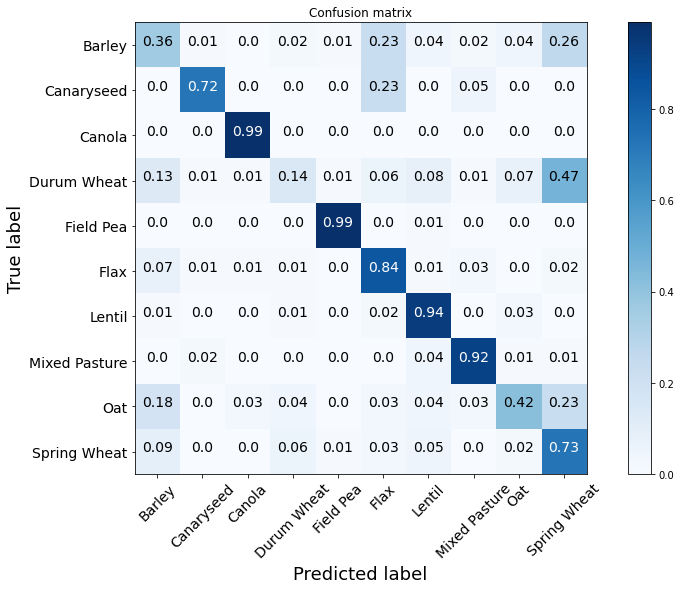

In [ ]:

#models=["CM_diag_V7_Nadam.h5","PolSAR_V7_Nadam.h5"]
model_name = "CM_diag_V10_Nadam.h5"
save_model_name = "/content/drive/My Drive/Datasets/AgriSAR_Paper2/Models/V6_to_V10/"+model_name
model_CS = load_model(save_model_name, custom_objects={'w_categorical_crossentropy': ncce})
# Report + confusion matrix
classes = ['Barley', 'Canaryseed', 'Canola', 'Durum Wheat', 'Field Pea', 'Flax', 'Lentil', 'Mixed Pasture', 'Oat', 'Spring Wheat']

y_pred=np.argmax(model_CS.predict(X_for_testing), axis=-1)
eval_model(y_test_CM0,y_pred,classes,model_name=model_name) 
cm = confusion_matrix(y_test_CM0, y_pred,normalize='true')
cm = np.round(cm, 2)
plot_my_confusion_matrix(cm, classes, cmap=plt.cm.Blues,save=1,model_name=model_name)

# Performance with reduced classes

In [ ]:
y_train0 = y_train_CM0 # enable for CM
y_test0 = y_test_CM0

In [ ]:
y_train_red=y_train0.copy() 
y_train_red=np.where(y_train0==0,0,y_train_red) # Barley
y_train_red=np.where(y_train0==1,0,y_train_red) # Canaray seed
y_train_red=np.where(y_train0==2,1,y_train_red) # Canola
y_train_red=np.where(y_train0==3,0,y_train_red) # Durum wheat
y_train_red=np.where(y_train0==4,2,y_train_red) # field Peas 
y_train_red=np.where(y_train0==5,3,y_train_red) # Flax
y_train_red=np.where(y_train0==6,4,y_train_red) # Lentil
y_train_red=np.where(y_train0==7,5,y_train_red) # Mixed Pasture
y_train_red=np.where(y_train0==8,0,y_train_red) # Oat
y_train_red=np.where(y_train0==9,0,y_train_red) # spring wheat

y_test_red=y_test0.copy() 
y_test_red=np.where(y_test0==0,0,y_test_red) # Barley
y_test_red=np.where(y_test0==1,0,y_test_red) # Canaray seed
y_test_red=np.where(y_test0==2,1,y_test_red) # Canola
y_test_red=np.where(y_test0==3,0,y_test_red) # Durum wheat
y_test_red=np.where(y_test0==4,2,y_test_red) # field Peas 
y_test_red=np.where(y_test0==5,3,y_test_red) # Flax
y_test_red=np.where(y_test0==6,4,y_test_red) # Lentil
y_test_red=np.where(y_test0==7,5,y_test_red) # Mixed Pasture
y_test_red=np.where(y_test0==8,0,y_test_red) # Oat
y_test_red=np.where(y_test0==9,0,y_test_red) # spring wheat

In [ ]:
class_weights_red = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_red),
                                                 y_train_red)
class_weight_dict_red = dict(enumerate(class_weights_red/class_weights_red.max())) 
# for test
# sample_weight_test_red=np.zeros(y_test_red.shape)
# for r in np.unique(y_test_red):
#   sample_weight_test=np.where(y_test_red==r,class_weight_dict_red[r],sample_weight_test_red)

# Create an array as big as the training samples.
# To each sample assign a weight depending on its class weight
sample_weight_red=np.zeros(y_train_red.shape) 
# fill the array with a sample weight equal to the class weight
for r in np.unique(y_train_red):
  sample_weight_red=np.where(y_train_red==r,class_weight_dict_red[r],sample_weight_red) 
print(np.unique(sample_weight_red))
print(sample_weight_red.shape)

w_array_red = np.ones((6,6))
for i in range(6):
  w_array_red[:,i]=class_weight_dict_red[i]
for i in range(6):
  w_array_red[i,i]=1
#w_array_red

ncce_red = partial(w_categorical_crossentropy, weights=w_array_red)
ncce_red.__name__ ='w_categorical_crossentropy_red'

[0.10154751 0.18489094 0.33461818 0.44688184 0.7257105  1.        ]
(1176829,)


                     NN_All_small
f1_macro                 0.839412
G_mean_macro             0.944128
Balanced accuracy        0.908159
Imbalanced accuracy      0.910114
 
               precision    recall  f1-score        support
Cereals         0.953604  0.865184  0.907245  142394.000000
Canola          0.979460  0.995104  0.987220   82520.000000
Field Pea       0.981483  0.930313  0.955214   44327.000000
Flax            0.712349  0.827259  0.765516   18988.000000
Lentil          0.434614  0.921123  0.590576    5946.000000
Mixed Pasture   0.764139  0.909971  0.830703   23459.000000
accuracy        0.910114  0.910114  0.910114       0.910114
macro avg       0.804275  0.908159  0.839412  317634.000000
weighted avg    0.926081  0.910114  0.914663  317634.000000
 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

saving CM_diag_red_V7_Nadam.h5 ...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

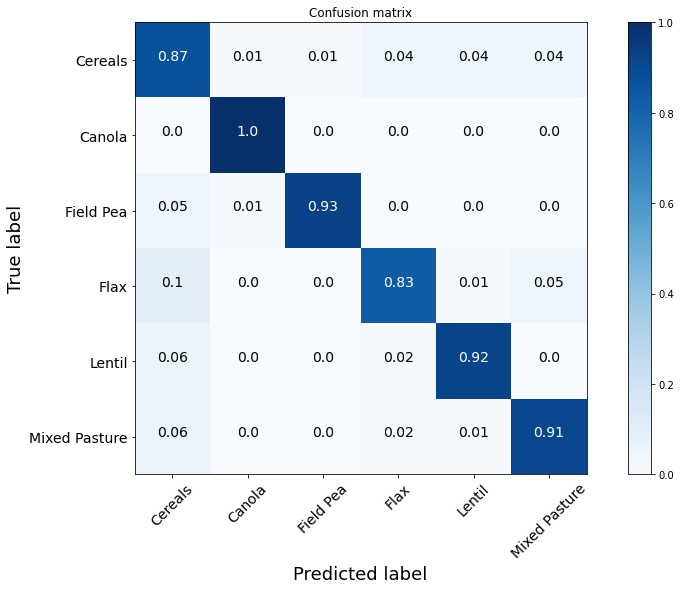

In [ ]:
model_name_red = "CM_diag_red_V10_Nadam.h5"
save_model_name = "/content/drive/My Drive/Datasets/AgriSAR_Paper2/Models/V6_to_V10/"+model_name_red
model_CS_red = load_model(save_model_name, custom_objects={'w_categorical_crossentropy_red': ncce_red})
classes_red = ['Cereals', 'Canola', 'Field Pea', 'Flax', 'Lentil', 'Mixed Pasture']
y_pred_red=np.argmax(model_CS_red.predict(X_for_testing), axis=-1)
eval_model(y_test_red,y_pred_red,classes_red,model_name=model_name_red) 
cm = confusion_matrix(y_test_red,y_pred_red,normalize='true')
cm = np.round(cm, 2)
plot_my_confusion_matrix(cm, classes_red, cmap=plt.cm.Blues,save=1,model_name=model_name_red)

# PolSAR 10 classes

In [ ]:
### Read PolSAR datasets
print("Reading PolSAR features test datasets ...")
root="/content/drive/My Drive/Datasets/AgriSAR_Paper2/Final_datasets/PolSAR_F/V10/"
layer_name = "y_train.npy"
y_train0=np.load(root + layer_name,  allow_pickle=True)
layer_name = "y_test.npy"
y_test0=np.load(root + layer_name,  allow_pickle=True)
print(Counter(y_train0))

print("Reading training labels ...")
layer_name = "X_train.npy"
X_train0=np.load(root + layer_name,  allow_pickle=True)
print("Reading testing labels ...")
layer_name = "X_test.npy"
X_test0=np.load(root + layer_name,  allow_pickle=True)
print("Done")

print("Scaling ...")     
sc = MinMaxScaler()   
X_train = sc.fit_transform(X_train0)
X_test = sc.transform(X_test0)

print("Reshaping as 2d images ...")
X_train_2d=X_train.reshape(X_train.shape[0],N_images,N_features,1)
X_test_2d=X_test.reshape(X_test.shape[0],N_images,N_features,1)

Reading PolSAR features test datasets ...
Counter({9.0: 347355, 2.0: 260715, 4.0: 155104, 7.0: 94766, 5.0: 67502, 0.0: 66061, 3.0: 63305, 6.0: 57005, 1.0: 34693, 8.0: 31703})
Reading training labels ...
Reading testing labels ...
Done
Scaling ...
Reshaping as 2d images ...


In [ ]:
#convert class vectors to binary class matrices (as required by the categorical cross entropy loss)
# from keras.utils import np_utils
# print(y_train0[0])
# Y_train = np_utils.to_categorical(y_train0, np.unique(y_train0).shape[0])
# Y_test = np_utils.to_categorical(y_test0, np.unique(y_test0).shape[0])
# print(Y_train[0])

# y_for_training = Y_train
# y_for_testing = Y_test
# y_for_testing_sparse = y_test0

# Enable for PolSAR input data
X_for_training = X_train_2d
X_for_testing  = X_test_2d
#X_for_validating=X_train_lev2_2d

                     NN_All_small
f1_macro                 0.717630
G_mean_macro             0.844913
Balanced accuracy        0.727868
Imbalanced accuracy      0.834680
 
               precision    recall  f1-score       support
Barley          0.458225  0.454713  0.456463   17875.00000
Canaryseed      0.803362  0.596294  0.684511    8256.00000
Canola          0.990942  0.993450  0.992195   74662.00000
Durum Wheat     0.301875  0.193699  0.235981   12633.00000
Field Pea       0.989019  0.990023  0.989521   44303.00000
Flax            0.687096  0.867739  0.766924   20452.00000
Lentil          0.604521  0.954572  0.740250   15211.00000
Mixed Pasture   0.920261  0.938856  0.929466   24794.00000
Oat             0.649655  0.495805  0.562398    8344.00000
Spring Wheat    0.845296  0.793525  0.818593  100448.00000
accuracy        0.834680  0.834680  0.834680       0.83468
macro avg       0.725025  0.727868  0.717630  326978.00000
weighted avg    0.834408  0.834680  0.830694  326978.00000
 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

saving PolSAR_V10_Nadam.h5 ...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

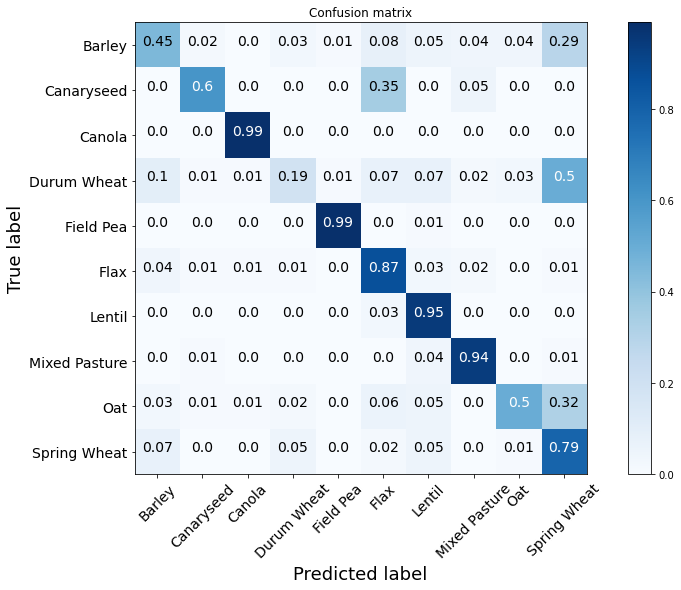

In [ ]:
model_name = "PolSAR_V10_Nadam.h5"
save_model_name = "/content/drive/My Drive/Datasets/AgriSAR_Paper2/Models/V6_to_V10/"+model_name
model_CS_PolSAR = load_model(save_model_name, custom_objects={'w_categorical_crossentropy': ncce})
# Report + confusion matrix
classes = ['Barley', 'Canaryseed', 'Canola', 'Durum Wheat', 'Field Pea', 'Flax', 'Lentil', 'Mixed Pasture', 'Oat', 'Spring Wheat']

y_pred_PolSAR=np.argmax(model_CS_PolSAR.predict(X_for_testing), axis=-1)
eval_model(y_test_CM0,y_pred_PolSAR,classes,model_name=model_name) 
cm = confusion_matrix(y_test_CM0, y_pred_PolSAR,normalize='true')
cm = np.round(cm, 2)
plot_my_confusion_matrix(cm, classes, cmap=plt.cm.Blues,save=1,model_name=model_name)

# PolSAR reduced

                     NN_All_small
f1_macro                 0.866614
G_mean_macro             0.956687
Balanced accuracy        0.927653
Imbalanced accuracy      0.933313
 
               precision    recall  f1-score        support
Cereals         0.973346  0.901702  0.936155  142394.000000
Canola          0.979186  0.995940  0.987492   82520.000000
Field Pea       0.983885  0.957250  0.970384   44327.000000
Flax            0.768641  0.871340  0.816775   18988.000000
Lentil          0.445466  0.928692  0.602115    5946.000000
Mixed Pasture   0.863789  0.910994  0.886763   23459.000000
accuracy        0.933313  0.933313  0.933313       0.933313
macro avg       0.835719  0.927653  0.866614  317634.000000
weighted avg    0.946124  0.933313  0.937232  317634.000000
 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

saving PolSAR_red_V7_Nadam.h5 ...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

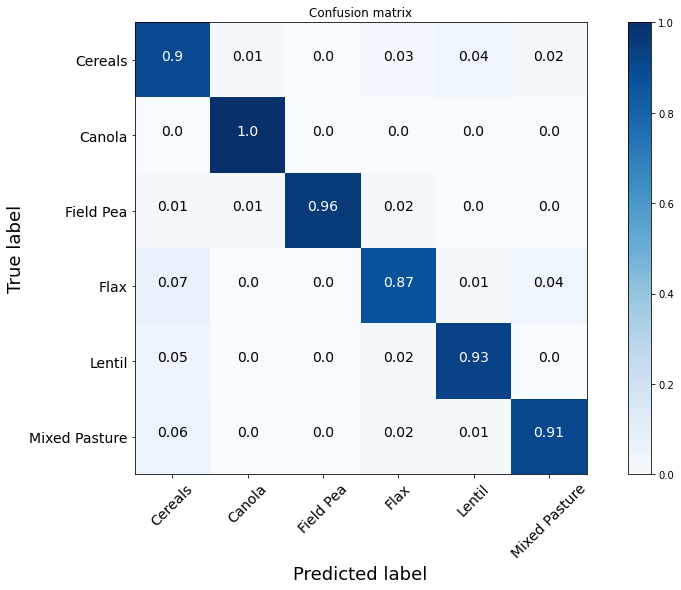

In [ ]:
model_name_red = "PolSAR_red_V10_Nadam.h5"
save_model_name = "/content/drive/My Drive/Datasets/AgriSAR_Paper2/Models/V6_to_V10/"+model_name_red
model_CS_red = load_model(save_model_name, custom_objects={'w_categorical_crossentropy_red': ncce_red})
classes_red = ['Cereals', 'Canola', 'Field Pea', 'Flax', 'Lentil', 'Mixed Pasture']
y_pred_red=np.argmax(model_CS_red.predict(X_for_testing), axis=-1)
eval_model(y_test_red,y_pred_red,classes_red,model_name=model_name_red) 
cm = confusion_matrix(y_test_red,y_pred_red,normalize='true')
cm = np.round(cm, 2)
plot_my_confusion_matrix(cm, classes_red, cmap=plt.cm.Blues,save=1,model_name=model_name_red)